<a href="https://colab.research.google.com/github/erfunmirzaei/DOL-Project2/blob/main/Project2_DOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition  


In this project, we implemented distributed deep learning algorithms as one case study of distributed optimization algorithms both for the data-parallel and data-distributed cases.

We used the CIFAR10 dataset and a convolution neural network to accomplish this. Our first step in training the network was centralized, as is standard in deep learning. Then we implemented the GoSGD algorithm, one of the most famous algorithms in distributed deep learning. In the following, different weight matrices were tested. Then, we assumed that the communication between clients was noisy, and the result was compared with previous cases. Finally, we implemented another gossip-based distributed optimization algorithm, SGP, and compared the result with GoSGD.

In the second part, we consider the case in which the data is distributed between clients, but despite the federated learning, there is no coordinator. For this part, we used a modified version of the GoSGD Algorithm and distributed the data in an iid and uniform manner between clients. Finally, the results are compared with the first project.


In [ ]:
#Importing required libraries 
import numpy as np
import matplotlib.pyplot as plt
import math 
import os, sys 
import random 
import copy
import string
import pickle

import torch 
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from typing import Callable, List, Optional, Tuple
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence 
from torch.optim.lr_scheduler import MultiStepLR, StepLR
import torch.optim as optim

from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [ ]:
device

device(type='cuda', index=0)

## Network

In [ ]:
class Deep_CNN(nn.Module):
    """
    Implement the network architecture which was used in "Personalized Federated Learning: A Meta-Learning Approach" Paper.
    """
    def __init__(self, num_classes):
        super(Deep_CNN, self).__init__() 

        # First layer
        self.conv1 = nn.Conv2d(3, 64, 5) 
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second layer
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third layer
        self.conv3 = nn.Conv2d(128, 64, 3)
        
        # Classifier 
        self.fc = nn.Linear(256,num_classes)

        # Activation Function 
        self.relu = nn.ReLU()     

        # Dropout 
        self.dropout = nn.Dropout()
           
    
    def forward(self,x):
        # First Layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        # Second Layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Second Layer
        x = self.conv3(x)
        x = self.relu(x)

        x = torch.flatten(x, start_dim = 1)
        x = self.dropout(x)

        #  Classifier
        x = self.fc(x)

        return x


# Centralized

## Preprocessing 

In [ ]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.CenterCrop(28)] )

torch.manual_seed(2045)
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


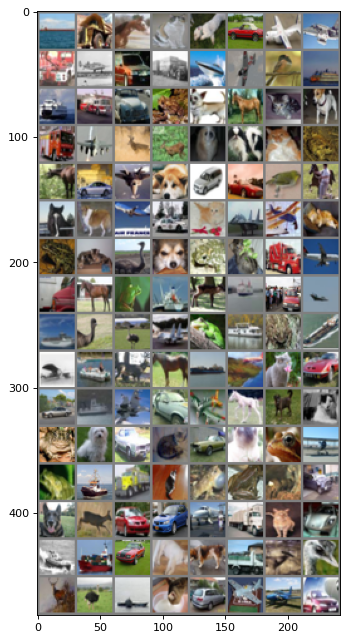

 ship truck horse   cat   dog   car plane plane truck plane   car truck  ship plane  bird  ship  ship truck   car  frog   dog horse   cat   dog truck plane  deer  deer   dog   dog   cat  frog horse   car plane   dog   car   car  bird horse horse   dog plane   car   cat plane plane   cat  frog   cat  bird   dog  frog   cat truck plane truck horse  frog  ship  deer  ship   car plane  ship  bird  bird plane  frog  ship  frog  ship plane  ship  deer horse  ship plane   cat   car   car  ship plane   car plane horse   dog   cat  frog   dog   car   cat   car   cat  frog plane  frog  ship truck   cat  frog  frog  deer   car   dog  deer   car   car plane truck   cat   car  ship  ship   car   dog   dog truck  deer  bird  deer  bird  ship   cat   car plane plane   car


In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 10), dpi=80)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Sanity Check 
(try to overfit on a mini batch)

In [ ]:
# Model 
Net = Deep_CNN(10)
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-4)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99) 

train_losses = []
train_accs = []

validation_losses = []
val_accs = []

dataiter = iter(trainloader)
train_data, train_labels = dataiter.next()

val_dataiter = iter(testloader)
val_data, val_labels = val_dataiter.next()

max_epochs = 1000

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    # Transfer to GPU
    train_data, train_labels = train_data.to(device), train_labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = Net(train_data)

    loss = criterion(batch_train_outputs, train_labels.long())
    loss.backward()
    optimizer.step()
    # scheduler.step()
    # print statistics
    running_trainloss += loss.item()
    running_loss += loss.item()

    train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

    if train_cnt % 100 == 99:    # print every 10 mini-batches
        print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
        running_loss = 0.0
    
    train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        #for val_data, val_labels in tqdm(validation_generator):
        # Transfer to GPU
        val_data, val_labels = val_data.to(device), val_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(val_data)
        
        val_loss = criterion(batch_outputs, val_labels.long())

        running_valloss += val_loss.item()
        running_loss += val_loss.item()

        val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

        if val_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0

        val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

  0%|          | 0/1000 [00:00<?, ?it/s]

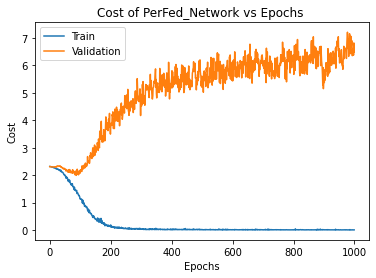

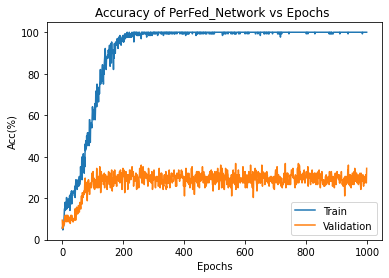

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of PerFed_Network vs Epochs ")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of PerFed_Network vs Epochs ")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

## Centeralized Training 

In [ ]:
torch.manual_seed(2045)
# Model 
Net = Deep_CNN(10)
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-4)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99) 

train_losses = []
train_accs = []

validation_losses = []
val_accs = []

max_epochs = 15

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for train_data, train_labels in tqdm(trainloader):
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Net(train_data)

        loss = criterion(batch_train_outputs, train_labels.long())
        loss.backward()
        optimizer.step()
        # scheduler.step()
        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if train_cnt % 100 == 99:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 100))
            running_loss = 0.0
        
        train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in tqdm(testloader):
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(val_data)
            
            val_loss = criterion(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 50 == 49:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 50))
                running_loss = 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 1 : 2.189130
Cost of Train data after 200 iterations in epoch 1 : 1.856795
Cost of Train data after 300 iterations in epoch 1 : 1.694525


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 1 : 1.573448


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 2 : 1.511433
Cost of Train data after 200 iterations in epoch 2 : 1.455095
Cost of Train data after 300 iterations in epoch 2 : 1.402490


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 2 : 1.329817


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 3 : 1.317609
Cost of Train data after 200 iterations in epoch 3 : 1.284150
Cost of Train data after 300 iterations in epoch 3 : 1.215393


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 3 : 1.180927


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 4 : 1.150794
Cost of Train data after 200 iterations in epoch 4 : 1.129078
Cost of Train data after 300 iterations in epoch 4 : 1.123582


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 4 : 1.119541


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 5 : 1.055350
Cost of Train data after 200 iterations in epoch 5 : 1.042133
Cost of Train data after 300 iterations in epoch 5 : 1.025754


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 5 : 1.037401


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 6 : 0.969491
Cost of Train data after 200 iterations in epoch 6 : 0.954569
Cost of Train data after 300 iterations in epoch 6 : 0.943047


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 6 : 0.975242


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 7 : 0.887718
Cost of Train data after 200 iterations in epoch 7 : 0.870814
Cost of Train data after 300 iterations in epoch 7 : 0.888704


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 7 : 0.925505


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 8 : 0.823432
Cost of Train data after 200 iterations in epoch 8 : 0.821359
Cost of Train data after 300 iterations in epoch 8 : 0.821631


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 8 : 0.919332


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 9 : 0.786205
Cost of Train data after 200 iterations in epoch 9 : 0.778552
Cost of Train data after 300 iterations in epoch 9 : 0.792582


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 9 : 0.899243


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 10 : 0.730681
Cost of Train data after 200 iterations in epoch 10 : 0.759022
Cost of Train data after 300 iterations in epoch 10 : 0.746865


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 10 : 0.873212


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 11 : 0.707962
Cost of Train data after 200 iterations in epoch 11 : 0.704146
Cost of Train data after 300 iterations in epoch 11 : 0.714375


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 11 : 0.887507


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 12 : 0.674000
Cost of Train data after 200 iterations in epoch 12 : 0.655156
Cost of Train data after 300 iterations in epoch 12 : 0.692542


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 12 : 0.848707


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 13 : 0.623658
Cost of Train data after 200 iterations in epoch 13 : 0.666871
Cost of Train data after 300 iterations in epoch 13 : 0.650178


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 13 : 0.830794


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 14 : 0.602003
Cost of Train data after 200 iterations in epoch 14 : 0.614010
Cost of Train data after 300 iterations in epoch 14 : 0.604035


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 14 : 0.819913


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 15 : 0.582979
Cost of Train data after 200 iterations in epoch 15 : 0.593926
Cost of Train data after 300 iterations in epoch 15 : 0.596233


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 15 : 0.861013


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 16 : 0.553033
Cost of Train data after 200 iterations in epoch 16 : 0.543784
Cost of Train data after 300 iterations in epoch 16 : 0.565234


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 16 : 0.819109


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 17 : 0.527841
Cost of Train data after 200 iterations in epoch 17 : 0.526483
Cost of Train data after 300 iterations in epoch 17 : 0.563672


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 17 : 0.829810


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 18 : 0.486111
Cost of Train data after 200 iterations in epoch 18 : 0.498794
Cost of Train data after 300 iterations in epoch 18 : 0.539111


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 18 : 0.861243


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 19 : 0.481499
Cost of Train data after 200 iterations in epoch 19 : 0.482525
Cost of Train data after 300 iterations in epoch 19 : 0.509127


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 19 : 0.842485


  0%|          | 0/391 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 20 : 0.455222
Cost of Train data after 200 iterations in epoch 20 : 0.479764
Cost of Train data after 300 iterations in epoch 20 : 0.485203


  0%|          | 0/79 [00:00<?, ?it/s]

Cost of Validation data after 50 iterations in epoch 20 : 0.824268


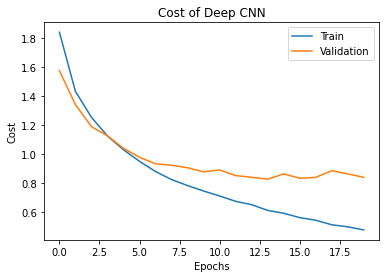

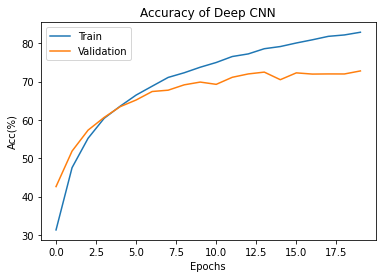

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of Deep CNN")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of Deep CNN")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/PerFed_Net.pth'
torch.save(Net.state_dict(), PATH)

# GOSGD (Time-varying Stochastic Matrix)

In [ ]:
def PROCESSMESSAGES(msg_i, w_dict_i, a_i):
    for msg in msg_i:
        w_dict_j , a_j = msg
        z = a_j + a_i
        for l in w_dict_i.keys():
            w_dict_i[l] = (a_j / z) * w_dict_j[l] + (a_i / z) * w_dict_i[l]
        a_i = a_i + a_j 
    
    msg_i = []
    return msg_i,w_dict_i, a_i

In [ ]:
def PUSHMESSAGE(msg_j, w_dict_i, a_i):
    msg_j.append((w_dict_i, a_i/2))
    return msg_j

In [ ]:
def UPDATETESTMODEL(test_net, train_nets):
    """
    test_net : nn.Module object  
    train_nets : list 
    """
    M = len(train_nets)
    test_dict = copy.deepcopy(test_net.state_dict()) 
    for k in test_dict.keys():
        test_dict[k] = torch.zeros_like(test_dict[k])

    for i in range(M):
        for l in test_dict.keys():
            test_dict[l] += (1/M) * train_nets[i].state_dict()[l]

    return test_dict


In [ ]:
# Hyper parameters
torch.manual_seed(2045)
batch_size = 128
M = 8 # num_workers
p = 1

# Model 
Nets = []
optimizers = []
train_iters = []
# test_iters = []
msgs = [[] for i in range(M)]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.CenterCrop(28)] )

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

for i in range(M):
    Nets.append(Deep_CNN(10))
    Nets[i].to(device)
    torch.manual_seed(i)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    train_iters.append(iter(trainloader))
    # test_iters.append(iter(torch.utils.data.DataLoader(testset, batch_size=batch_size,
    #                                      shuffle=False, num_workers=2)))

optimizers.append(optim.SGD(Nets[0].parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-4))
for i in range(1,M):
    Nets[i].load_state_dict(copy.deepcopy(Nets[0].state_dict()))
    optimizers.append(optim.SGD(Nets[i].parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-4))

alphas = [1/M] * M 

test_Net = Deep_CNN(10)
test_Net.to(device)

# Define Loss function and Optimizer
criterion2 = nn.CrossEntropyLoss()
# scheduler2 = StepLR(optimizer2, step_size=1, gamma=0.99) 

train_losses2 = []
train_accs2 = []

validation_losses2 = []
val_accs2 = []

max_iters = 500

# Loop over iters
for itr in tqdm(range(max_iters)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for i in range(M):
        msgs[i],w_dict_i , a_i = PROCESSMESSAGES(msgs[i], Nets[i].state_dict(), alphas[i]) 
        Nets[i].load_state_dict(w_dict_i)
        alphas[i] = a_i
        try :
            train_data, train_labels = train_iters[i].next()
        except:
            train_iters[i] = iter(trainloader)
            train_data, train_labels = train_iters[i].next()
        
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)

        # zero the parameter gradients
        optimizers[i].zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Nets[i](train_data)

        loss = criterion2(batch_train_outputs, train_labels.long())
        loss.backward()
        clip_grad_norm_(Nets[i].parameters(), 5)
        optimizers[i].step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if itr % 100 == 0:    # print every 10 mini-batches
            print("Cost of Train data for worker %i in iterations %i: %f" %(train_cnt + 1,itr + 1, running_loss))
        running_loss = 0.0
        
        train_cnt += 1

        if np.random.binomial(1,p) :
            j = random.choice(list(range(M)))
            msgs[j] = PUSHMESSAGE(msgs[j], Nets[i].state_dict(), alphas[i])
        
    # Validation
    # get average
    test_Net.load_state_dict(UPDATETESTMODEL(test_Net, Nets))
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = test_Net(val_data)
            
            val_loss = criterion2(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 79 == 78:    # print every 10 mini-batches
                print("Cost of Validation data in iteration %i : %f" %(itr + 1, running_loss / 79))
                running_loss = 0.0

            val_cnt += 1

    train_losses2.append(running_trainloss / train_cnt)
    train_accs2.append(train_acc / train_cnt * 100)
    validation_losses2.append(running_valloss / val_cnt)
    val_accs2.append(val_acc / val_cnt * 100)


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data for worker 1 in iterations 1: 2.304193
Cost of Train data for worker 2 in iterations 1: 2.300972
Cost of Train data for worker 3 in iterations 1: 2.297413
Cost of Train data for worker 4 in iterations 1: 2.304885
Cost of Train data for worker 5 in iterations 1: 2.300929
Cost of Train data for worker 6 in iterations 1: 2.306524
Cost of Train data for worker 7 in iterations 1: 2.303264
Cost of Train data for worker 8 in iterations 1: 2.304688
Cost of Validation data in iteration 1 : 2.305379


KeyboardInterrupt: ignored

In [ ]:
# Loop over iters
for itr in tqdm(range(max_iters)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for i in range(M):
        msgs[i],w_dict_i , a_i = PROCESSMESSAGES(msgs[i], Nets[i].state_dict(), alphas[i])
        Nets[i].load_state_dict(w_dict_i)
        alphas[i] = a_i
        try :
            train_data, train_labels = train_iters[i].next()
        except:
            train_iters[i] = iter(trainloader)
            train_data, train_labels = train_iters[i].next()
        
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)

        # zero the parameter gradients
        optimizers[i].zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Nets[i](train_data)

        loss = criterion2(batch_train_outputs, train_labels.long())
        loss.backward()
        clip_grad_norm_(Nets[i].parameters(), 1)
        optimizers[i].step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if itr % 100 == 0:    # print every 10 mini-batches
            print("Cost of Train data for worker %i in iterations %i: %f" %(train_cnt + 1,itr + 1, running_loss))
        running_loss = 0.0
        
        train_cnt += 1

        if np.random.binomial(1,p) :
            j = random.choice(list(range(M)))
            msgs[j] = PUSHMESSAGE(msgs[j], Nets[i].state_dict(), alphas[i])
        
    # Validation
    # get average
    test_Net.load_state_dict(UPDATETESTMODEL(test_Net, Nets))
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = test_Net(val_data)
            
            val_loss = criterion2(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 79 == 78:    # print every 10 mini-batches
                print("Cost of Validation data in iteration %i : %f" %(itr + 1, running_loss / 79))
                running_loss = 0.0

            val_cnt += 1

    train_losses2.append(running_trainloss / train_cnt)
    train_accs2.append(train_acc / train_cnt * 100)
    validation_losses2.append(running_valloss / val_cnt)
    val_accs2.append(val_acc / val_cnt * 100)


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data for worker 1 in iterations 1: 1.286270
Cost of Train data for worker 2 in iterations 1: 1.201221
Cost of Train data for worker 3 in iterations 1: 1.213109
Cost of Train data for worker 4 in iterations 1: 0.986884
Cost of Train data for worker 5 in iterations 1: 1.097561
Cost of Train data for worker 6 in iterations 1: 1.211627
Cost of Train data for worker 7 in iterations 1: 1.142717
Cost of Train data for worker 8 in iterations 1: 1.153046
Cost of Validation data in iteration 1 : 1.183181
Cost of Validation data in iteration 2 : 1.185635
Cost of Validation data in iteration 3 : 1.188922
Cost of Validation data in iteration 4 : 1.185367
Cost of Validation data in iteration 5 : 1.178535
Cost of Validation data in iteration 6 : 1.175951
Cost of Validation data in iteration 7 : 1.183955
Cost of Validation data in iteration 8 : 1.187005
Cost of Validation data in iteration 9 : 1.181729
Cost of Validation data in iteration 10 : 1.188930
Cost of Validation data in iteratio

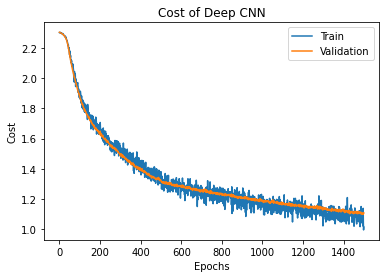

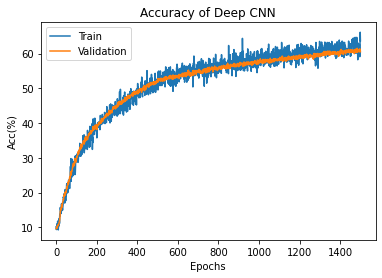

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses2)
    plt.plot(validation_losses2)
    plt.title("Cost of Deep CNN")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs2)
    plt.plot(val_accs2)
    plt.title("Accuracy of Deep CNN")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

## Save

In [ ]:
for i in range(M):
    PATH = '/content/drive/My Drive/Deep_CNN_GOSGD_'
    torch.save(Nets[i].state_dict(), PATH + str(i) + '.pth')


In [ ]:
with open('/content/drive/My Drive/Deep_CNN_GOSGD_train_losses2.txt', "wb") as fp:   #Pickling
    pickle.dump(train_losses2, fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_validation_losses2.txt', "wb") as fp:   #Pickling
    pickle.dump(validation_losses2, fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_train_accs2.txt', "wb") as fp:   #Pickling
    pickle.dump(train_accs2, fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_validation_accs2.txt', "wb") as fp:   #Pickling
    pickle.dump(val_accs2, fp)

## Load 





In [ ]:
for i in range(M):
    PATH = '/content/drive/My Drive/Deep_CNN_GOSGD_'
    Nets[i].load_state_dict(torch.load(PATH + str(i) + '.pth'))

In [ ]:
with open('/content/drive/My Drive/Deep_CNN_GOSGD_train_losses2.txt', 'rb') as fp:
    train_losses2 = pickle.load(fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_validation_losses2.txt', 'rb') as fp:
    validation_losses2 = pickle.load(fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_train_accs2.txt', 'rb') as fp:
    train_accs2 = pickle.load(fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_validation_accs2.txt', 'rb') as fp:
    val_accs2 = pickle.load(fp)

# GOSGD [Fixed Uniform Weights (Double Stochastic Matrix)]

In [ ]:
# Hyper parameters
torch.manual_seed(2045)
batch_size = 128
M = 8 # num_workers
p = 1

# Model 
Nets = []
optimizers = []
train_iters = []
# test_iters = []
msgs = [[] for i in range(M)]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.CenterCrop(28)] )

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

for i in range(M):
    Nets.append(Deep_CNN(10))
    Nets[i].to(device)
    torch.manual_seed(i)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    train_iters.append(iter(trainloader))
    # test_iters.append(iter(torch.utils.data.DataLoader(testset, batch_size=batch_size,
    #                                      shuffle=False, num_workers=2)))

optimizers.append(optim.SGD(Nets[0].parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-4))
for i in range(1,M):
    Nets[i].load_state_dict(copy.deepcopy(Nets[0].state_dict()))
    optimizers.append(optim.SGD(Nets[i].parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-4))

alphas = [1/M] * M 

test_Net = Deep_CNN(10)
test_Net.to(device)

# Define Loss function and Optimizer
criterion3 = nn.CrossEntropyLoss()
# scheduler3 = StepLR(optimizer3, step_size=1, gamma=0.99) 

train_losses3 = []
train_accs3 = []

validation_losses3 = []
val_accs3 = []

max_iters = 500

# Loop over iters
for itr in tqdm(range(max_iters)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for i in range(M):
        msgs[i],w_dict_i , a_i = PROCESSMESSAGES(msgs[i], Nets[i].state_dict(), alphas[i]) 
        Nets[i].load_state_dict(w_dict_i)
        # alphas[i] = a_i
        try :
            train_data, train_labels = train_iters[i].next()
        except:
            train_iters[i] = iter(trainloader)
            train_data, train_labels = train_iters[i].next()
        
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)

        # zero the parameter gradients
        optimizers[i].zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Nets[i](train_data)

        loss = criterion3(batch_train_outputs, train_labels.long())
        loss.backward()
        clip_grad_norm_(Nets[i].parameters(), 5)
        optimizers[i].step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if itr % 100 == 0:    # print every 10 mini-batches
            print("Cost of Train data for worker %i in iterations %i: %f" %(train_cnt + 1,itr + 1, running_loss))
        running_loss = 0.0
        
        train_cnt += 1

        if np.random.binomial(1,p) :
            j = random.choice(list(range(M)))
            msgs[j] = PUSHMESSAGE(msgs[j], Nets[i].state_dict(), alphas[i])
        
    # Validation
    # get average
    test_Net.load_state_dict(UPDATETESTMODEL(test_Net, Nets))
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = test_Net(val_data)
            
            val_loss = criterion3(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 79 == 78:    # print every 10 mini-batches
                print("Cost of Validation data in iteration %i : %f" %(itr + 1, running_loss / 79))
                running_loss = 0.0

            val_cnt += 1

    train_losses3.append(running_trainloss / train_cnt)
    train_accs3.append(train_acc / train_cnt * 100)
    validation_losses3.append(running_valloss / val_cnt)
    val_accs3.append(val_acc / val_cnt * 100)


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data for worker 1 in iterations 1: 2.304193
Cost of Train data for worker 2 in iterations 1: 2.300972
Cost of Train data for worker 3 in iterations 1: 2.297455
Cost of Train data for worker 4 in iterations 1: 2.304893
Cost of Train data for worker 5 in iterations 1: 2.300929
Cost of Train data for worker 6 in iterations 1: 2.306524
Cost of Train data for worker 7 in iterations 1: 2.303264
Cost of Train data for worker 8 in iterations 1: 2.304688
Cost of Validation data in iteration 1 : 2.305394
Cost of Validation data in iteration 2 : 2.305282
Cost of Validation data in iteration 3 : 2.304796
Cost of Validation data in iteration 4 : 2.304064
Cost of Validation data in iteration 5 : 2.303169
Cost of Validation data in iteration 6 : 2.303273
Cost of Validation data in iteration 7 : 2.302061
Cost of Validation data in iteration 8 : 2.301560
Cost of Validation data in iteration 9 : 2.300444
Cost of Validation data in iteration 10 : 2.299460
Cost of Validation data in iteratio

In [ ]:
# Loop over iters
for itr in tqdm(range(max_iters)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for i in range(M):
        msgs[i],w_dict_i , a_i = PROCESSMESSAGES(msgs[i], Nets[i].state_dict(), alphas[i]) 
        Nets[i].load_state_dict(w_dict_i)
        # alphas[i] = a_i
        try :
            train_data, train_labels = train_iters[i].next()
        except:
            train_iters[i] = iter(trainloader)
            train_data, train_labels = train_iters[i].next()
        
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)

        # zero the parameter gradients
        optimizers[i].zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Nets[i](train_data)

        loss = criterion3(batch_train_outputs, train_labels.long())
        loss.backward()
        clip_grad_norm_(Nets[i].parameters(), 5)
        optimizers[i].step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if itr % 100 == 0:    # print every 10 mini-batches
            print("Cost of Train data for worker %i in iterations %i: %f" %(train_cnt + 1,itr + 1, running_loss))
        running_loss = 0.0
        
        train_cnt += 1

        if np.random.binomial(1,p) :
            j = random.choice(list(range(M)))
            msgs[j] = PUSHMESSAGE(msgs[j], Nets[i].state_dict(), alphas[i])
        
    # Validation
    # get average
    test_Net.load_state_dict(UPDATETESTMODEL(test_Net, Nets))
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = test_Net(val_data)
            
            val_loss = criterion3(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 79 == 78:    # print every 10 mini-batches
                print("Cost of Validation data in iteration %i : %f" %(itr + 1, running_loss / 79))
                running_loss = 0.0

            val_cnt += 1

    train_losses3.append(running_trainloss / train_cnt)
    train_accs3.append(train_acc / train_cnt * 100)
    validation_losses3.append(running_valloss / val_cnt)
    val_accs3.append(val_acc / val_cnt * 100)

  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data for worker 1 in iterations 1: 0.975187
Cost of Train data for worker 2 in iterations 1: 1.078008
Cost of Train data for worker 3 in iterations 1: 0.929081
Cost of Train data for worker 4 in iterations 1: 1.235586
Cost of Train data for worker 5 in iterations 1: 1.142109
Cost of Train data for worker 6 in iterations 1: 1.196387
Cost of Train data for worker 7 in iterations 1: 1.046033
Cost of Train data for worker 8 in iterations 1: 1.037761
Cost of Validation data in iteration 1 : 1.083689
Cost of Validation data in iteration 2 : 1.088066
Cost of Validation data in iteration 3 : 1.080091
Cost of Validation data in iteration 4 : 1.082890
Cost of Validation data in iteration 5 : 1.087600
Cost of Validation data in iteration 6 : 1.084002
Cost of Validation data in iteration 7 : 1.081442
Cost of Validation data in iteration 8 : 1.081201
Cost of Validation data in iteration 9 : 1.084728
Cost of Validation data in iteration 10 : 1.082788
Cost of Validation data in iteratio

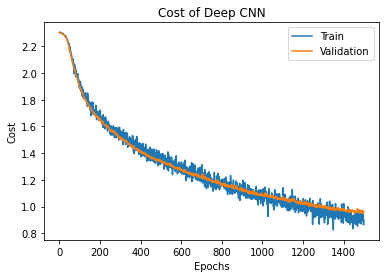

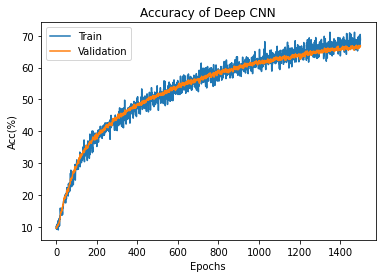

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses3)
    plt.plot(validation_losses3)
    plt.title("Cost of Deep CNN")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs3)
    plt.plot(val_accs3)
    plt.title("Accuracy of Deep CNN")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

## Save

In [ ]:
for i in range(M):
    PATH = '/content/drive/My Drive/Deep_CNN_GOSGD2_'
    torch.save(Nets[i].state_dict(), PATH + str(i) + '.pth')


In [ ]:
with open('/content/drive/My Drive/Deep_CNN_GOSGD_train_losses3.txt', "wb") as fp:   #Pickling
    pickle.dump(train_losses3, fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_validation_losses3.txt', "wb") as fp:   #Pickling
    pickle.dump(validation_losses3, fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_train_accs3.txt', "wb") as fp:   #Pickling
    pickle.dump(train_accs3, fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_validation_accs3.txt', "wb") as fp:   #Pickling
    pickle.dump(val_accs3, fp)

## Load 





In [ ]:
for i in range(M):
    PATH = '/content/drive/My Drive/Deep_CNN_GOSGD2_'
    Nets[i].load_state_dict(torch.load(PATH + str(i) + '.pth'))

In [ ]:
with open('/content/drive/My Drive/Deep_CNN_GOSGD_train_losses3.txt', 'rb') as fp:
    train_losses3 = pickle.load(fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_validation_losses3.txt', 'rb') as fp:
    validation_losses3 = pickle.load(fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_train_accs3.txt', 'rb') as fp:
    train_accs3 = pickle.load(fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_validation_accs3.txt', 'rb') as fp:
    val_accs3 = pickle.load(fp)

# GOSGD [Random Weights (Stochastic Matrix)]

In [ ]:
def PROCESSMESSAGES(msg_i, w_dict_i, a_i):
    for msg in msg_i:
        w_dict_j , a_j, j = msg
        z = a_j + a_i[j]
        for l in w_dict_i.keys():
            w_dict_i[l] = (a_j / z) * w_dict_j[l] + (a_i[j] / z) * w_dict_i[l]
        a_i[j] = a_i[j] + a_j 
    
    msg_i = []
    return msg_i,w_dict_i, a_i

In [ ]:
def PUSHMESSAGE(msg_j, w_dict_i, a_i_j):
    msg_j.append((w_dict_i, a_i_j/2, i))
    return msg_j

In [ ]:
def UPDATETESTMODEL(test_net, train_nets):
    """
    test_net : nn.Module object  
    train_nets : list 
    """
    M = len(train_nets)
    test_dict = copy.deepcopy(test_net.state_dict()) 
    for k in test_dict.keys():
        test_dict[k] = torch.zeros_like(test_dict[k])

    for i in range(M):
        for l in test_dict.keys():
            test_dict[l] += (1/M) * train_nets[i].state_dict()[l]

    return test_dict


In [ ]:
# Hyper parameters
torch.manual_seed(2045)
batch_size = 128
M = 8 # num_workers
p = 1

# Model 
Nets = []
optimizers = []
train_iters = []
# test_iters = []
msgs = [[] for i in range(M)]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.CenterCrop(28)] )

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

for i in range(M):
    Nets.append(Deep_CNN(10))
    Nets[i].to(device)
    torch.manual_seed(i)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    train_iters.append(iter(trainloader))
    # test_iters.append(iter(torch.utils.data.DataLoader(testset, batch_size=batch_size,
    #                                      shuffle=False, num_workers=2)))

optimizers.append(optim.SGD(Nets[0].parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-4))
for i in range(1,M):
    Nets[i].load_state_dict(copy.deepcopy(Nets[0].state_dict()))
    optimizers.append(optim.SGD(Nets[i].parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-4))

x = np.random.rand(M,M)
alphas = torch.Tensor(x / np.sum(x, axis = 1, keepdims = True))

test_Net = Deep_CNN(10)
test_Net.to(device)

# Define Loss function and Optimizer
criterion4 = nn.CrossEntropyLoss()
# scheduler4 = StepLR(optimizer4, step_size=1, gamma=0.99) 

train_losses4 = []
train_accs4 = []

validation_losses4 = []
val_accs4 = []

max_iters = 1000

# Loop over iters
for itr in tqdm(range(max_iters)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for i in range(M):
        msgs[i], w_dict_i , a_i = PROCESSMESSAGES(msgs[i], Nets[i].state_dict(), alphas[i,]) 
        Nets[i].load_state_dict(w_dict_i)
        alphas[i,] = a_i
        try :
            train_data, train_labels = train_iters[i].next()
        except:
            train_iters[i] = iter(trainloader)
            train_data, train_labels = train_iters[i].next()
        
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)

        # zero the parameter gradients
        optimizers[i].zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Nets[i](train_data)

        loss = criterion4(batch_train_outputs, train_labels.long())
        loss.backward()
        optimizers[i].step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if itr % 100 == 0:    # print every 10 mini-batches
            print("Cost of Train data for worker %i in iterations %i: %f" %(train_cnt + 1,itr + 1, running_loss))
        running_loss = 0.0
        
        train_cnt += 1

        if np.random.binomial(1,p) :
            j = random.choice(list(range(M)))
            msgs[j] = PUSHMESSAGE(msgs[j], Nets[i].state_dict(), alphas[i,j])
        
    # Validation
    # get average
    test_Net.load_state_dict(UPDATETESTMODEL(test_Net, Nets))
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = test_Net(val_data)
            
            val_loss = criterion4(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 79 == 78:    # print every 10 mini-batches
                print("Cost of Validation data in iteration %i : %f" %(itr + 1, running_loss / 79))
                running_loss = 0.0

            val_cnt += 1

    train_losses4.append(running_trainloss / train_cnt)
    train_accs4.append(train_acc / train_cnt * 100)
    validation_losses4.append(running_valloss / val_cnt)
    val_accs4.append(val_acc / val_cnt * 100)


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

Cost of Train data for worker 1 in iterations 1: 2.304193
Cost of Train data for worker 2 in iterations 1: 2.300972
Cost of Train data for worker 3 in iterations 1: 2.297455
Cost of Train data for worker 4 in iterations 1: 2.304930
Cost of Train data for worker 5 in iterations 1: 2.300929
Cost of Train data for worker 6 in iterations 1: 2.306524
Cost of Train data for worker 7 in iterations 1: 2.303264
Cost of Train data for worker 8 in iterations 1: 2.304661
Cost of Validation data in iteration 1 : 2.305399
Cost of Validation data in iteration 2 : 2.305287
Cost of Validation data in iteration 3 : 2.304731
Cost of Validation data in iteration 4 : 2.303948
Cost of Validation data in iteration 5 : 2.303053
Cost of Validation data in iteration 6 : 2.303194
Cost of Validation data in iteration 7 : 2.301937
Cost of Validation data in iteration 8 : 2.301399
Cost of Validation data in iteration 9 : 2.300333
Cost of Validation data in iteration 10 : 2.299406
Cost of Validation data in iteratio

In [ ]:
max_iters = 500

# Loop over iters
for itr in tqdm(range(max_iters)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for i in range(M):
        msgs[i], w_dict_i , a_i = PROCESSMESSAGES(msgs[i], Nets[i].state_dict(), alphas[i,]) 
        Nets[i].load_state_dict(w_dict_i)
        alphas[i,] = a_i
        try :
            train_data, train_labels = train_iters[i].next()
        except:
            train_iters[i] = iter(trainloader)
            train_data, train_labels = train_iters[i].next()
        
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)

        # zero the parameter gradients
        optimizers[i].zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Nets[i](train_data)

        loss = criterion4(batch_train_outputs, train_labels.long())
        loss.backward()
        optimizers[i].step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if itr % 100 == 0:    # print every 10 mini-batches
            print("Cost of Train data for worker %i in iterations %i: %f" %(train_cnt + 1,itr + 1, running_loss))
        running_loss = 0.0
        
        train_cnt += 1

        if np.random.binomial(1,p) :
            j = random.choice(list(range(M)))
            msgs[j] = PUSHMESSAGE(msgs[j], Nets[i].state_dict(), alphas[i,j])
        
    # Validation
    # get average
    test_Net.load_state_dict(UPDATETESTMODEL(test_Net, Nets))
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = test_Net(val_data)
            
            val_loss = criterion4(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 79 == 78:    # print every 10 mini-batches
                print("Cost of Validation data in iteration %i : %f" %(itr + 1, running_loss / 79))
                running_loss = 0.0

            val_cnt += 1

    train_losses4.append(running_trainloss / train_cnt)
    train_accs4.append(train_acc / train_cnt * 100)
    validation_losses4.append(running_valloss / val_cnt)
    val_accs4.append(val_acc / val_cnt * 100)

  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data for worker 1 in iterations 1: 0.898216
Cost of Train data for worker 2 in iterations 1: 1.125371
Cost of Train data for worker 3 in iterations 1: 0.907054
Cost of Train data for worker 4 in iterations 1: 1.264482
Cost of Train data for worker 5 in iterations 1: 1.121849
Cost of Train data for worker 6 in iterations 1: 1.234065
Cost of Train data for worker 7 in iterations 1: 1.043838
Cost of Train data for worker 8 in iterations 1: 1.001830
Cost of Validation data in iteration 1 : 1.077098
Cost of Validation data in iteration 2 : 1.083881
Cost of Validation data in iteration 3 : 1.071125
Cost of Validation data in iteration 4 : 1.073411
Cost of Validation data in iteration 5 : 1.076990
Cost of Validation data in iteration 6 : 1.075850
Cost of Validation data in iteration 7 : 1.073225
Cost of Validation data in iteration 8 : 1.072904
Cost of Validation data in iteration 9 : 1.078341
Cost of Validation data in iteration 10 : 1.072780
Cost of Validation data in iteratio

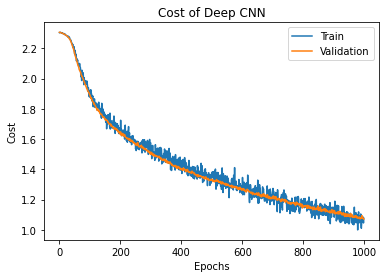

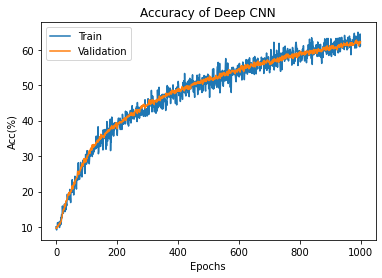

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses4)
    plt.plot(validation_losses4)
    plt.title("Cost of Deep CNN")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs4)
    plt.plot(val_accs4)
    plt.title("Accuracy of Deep CNN")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

## Save

In [ ]:
for i in range(M):
    PATH = '/content/drive/My Drive/Deep_CNN_GOSGD3_'
    torch.save(Nets[i].state_dict(), PATH + str(i) + '.pth')


In [ ]:
with open('/content/drive/My Drive/Deep_CNN_GOSGD_train_losses4.txt', "wb") as fp:   #Pickling
    pickle.dump(train_losses4, fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_validation_losses4.txt', "wb") as fp:   #Pickling
    pickle.dump(validation_losses4, fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_train_accs4.txt', "wb") as fp:   #Pickling
    pickle.dump(train_accs4, fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_validation_accs4.txt', "wb") as fp:   #Pickling
    pickle.dump(val_accs4, fp)

## Load 





In [ ]:
for i in range(M):
    PATH = '/content/drive/My Drive/Deep_CNN_GOSGD3_'
    Nets[i].load_state_dict(torch.load(PATH + str(i) + '.pth'))

In [ ]:
with open('/content/drive/My Drive/Deep_CNN_GOSGD_train_losses4.txt', 'rb') as fp:
    train_losses4 = pickle.load(fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_validation_losses4.txt', 'rb') as fp:
    validation_losses4 = pickle.load(fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_train_accs4.txt', 'rb') as fp:
    train_accs4 = pickle.load(fp)

with open('/content/drive/My Drive/Deep_CNN_GOSGD_validation_accs4.txt', 'rb') as fp:
    val_accs4 = pickle.load(fp)

# Distributed Stochastic Gradient 

# SGP 

In [ ]:
# Hyper parameters
torch.manual_seed(2045)
batch_size = 128
M = 8 # num_workers
p = 1

# Model 
Nets = []
optimizers = []
train_iters = []
# test_iters = []
msgs = [[] for i in range(M)]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.CenterCrop(28)] )

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

for i in range(M):
    Nets.append(Deep_CNN(10))
    Nets[i].to(device)
    torch.manual_seed(i)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    train_iters.append(iter(trainloader))
    # test_iters.append(iter(torch.utils.data.DataLoader(testset, batch_size=batch_size,
    #                                      shuffle=False, num_workers=2)))

optimizers.append(optim.SGD(Nets[0].parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-4))
for i in range(1,M):
    Nets[i].load_state_dict(copy.deepcopy(Nets[0].state_dict()))
    optimizers.append(optim.SGD(Nets[i].parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-4))

alphas = [1/M] * M 

test_Net = Deep_CNN(10)
test_Net.to(device)

# Define Loss function and Optimizer
criterion2 = nn.CrossEntropyLoss()
# scheduler2 = StepLR(optimizer2, step_size=1, gamma=0.99) 

train_losses2 = []
train_accs2 = []

validation_losses2 = []
val_accs2 = []

max_iters = 500

# Loop over iters
for itr in tqdm(range(max_iters)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for i in range(M):
        w_dict_i , a_i = PROCESSMESSAGES(msgs[i], Nets[i].state_dict(), alphas[i]) 
        Nets[i].load_state_dict(w_dict_i)
        alphas[i] = a_i
        try :
            train_data, train_labels = train_iters[i].next()
        except:
            train_iters[i] = iter(trainloader)
            train_data, train_labels = train_iters[i].next()
        
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)

        # zero the parameter gradients
        optimizers[i].zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Nets[i](train_data)

        loss = criterion2(batch_train_outputs, train_labels.long())
        loss.backward()
        clip_grad_norm_(Nets[i].parameters(), 5)
        optimizers[i].step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if itr % 100 == 0:    # print every 10 mini-batches
            print("Cost of Train data for worker %i in iterations %i: %f" %(train_cnt + 1,itr + 1, running_loss))
        running_loss = 0.0
        
        train_cnt += 1

        if np.random.binomial(1,p) :
            j = random.choice(list(range(M)))
            msgs[j] = PUSHMESSAGE(msgs[j], Nets[i].state_dict(), alphas[i])
        
    # Validation
    # get average
    test_Net.load_state_dict(UPDATETESTMODEL(test_Net, Nets))
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = test_Net(val_data)
            
            val_loss = criterion2(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 79 == 78:    # print every 10 mini-batches
                print("Cost of Validation data in iteration %i : %f" %(itr + 1, running_loss / 79))
                running_loss = 0.0

            val_cnt += 1

    train_losses2.append(running_trainloss / train_cnt)
    train_accs2.append(train_acc / train_cnt * 100)
    validation_losses2.append(running_valloss / val_cnt)
    val_accs2.append(val_acc / val_cnt * 100)
